In [139]:
%matplotlib inline

import os
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal, stats
import seaborn as sns

from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools import eval_measures
import statsmodels.regression
import statsmodels.tools
import warnings
#from fbprophet import Prophet
warnings.filterwarnings('ignore')
from math import sqrt


## some datetime conversion warning
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Always make it pretty.
plt.style.use('ggplot')


In [174]:
#Some borrowed functions Galvanize time series lecture 2020
def plot_trend_data(ax, name, series):
    ax.plot(series.index.date, series)
    ax.set_title("Seasonal Trend {}".format(name))

def create_monthly_dummies(series):
    month = series.index.month
    # Only take 11 of the 12 dummies to avoid strict colinearity.
    return pd.get_dummies(month).iloc[:, :11]



def create_weekly_dummies(series):
    week = series.index.week
    # Only take 51 of the 52 dummies to avoid strict colinearity.
    return pd.get_dummies(week).iloc[:, :51]

def fit_seasonal_trend(series):
    dummies = create_monthly_dummies(series)
    X = sm.add_constant(dummies.values, prepend=False)
    seasonal_model = sm.OLS(series.values, X).fit()
    return seasonal_model.predict(X)

def fit_weekly_seasonal_trend(series):
    dummies = create_weekly_dummies(series)
    X = sm.add_constant(dummies.values, prepend=False)
    seasonal_model = sm.OLS(series.values, X).fit()
    return seasonal_model.predict(X)

def plot_seasonal_trend(ax, name, series):
    seasons_average_trend = fit_seasonal_trend(series)
    plot_trend_data(ax, name, series, )
    ax.plot(series.index.date, seasons_average_trend, '-')
    plt.ylabel("Confirmed\nInfections", fontsize=24) 
    plt.xlabel("Date", fontsize=24)
    plt.savefig("images/monthly seasonal trend", bbox_inches = "tight") ;

def plot_weekly_seasonal_trend(ax, name, series):
    seasons_average_trend = fit_weekly_seasonal_trend(series)
    plot_trend_data(ax, name, series, )
    ax.plot(series.index.date, seasons_average_trend, '-')
    plt.ylabel("Confirmed\nInfections", fontsize=24) 
    plt.xlabel("Date", fontsize=24)
    plt.savefig("images/weekly seasnoal detrend", bbox_inches = "tight") ;

def rms(y_test, y_predict):
    return (sqrt(mean_squared_error(y_test, y_predict[0:68])))

In [141]:
stat_code = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "VI" ,"WA", "WV", "WI", "WY", "PR"]

state = ['Alabama','Alaska','Arizona', 'Arkansas', 'California', 'Colorado','Connecticut',"District of Columbia",'Delaware','Florida',
         'Georgia','Hawaii','Idaho','Illinois','Indiana','Iowa','Kansas', 'Kentucky','Louisiana','Maine',
 'Maryland','Massachusetts','Michigan','Minnesota','Mississippi', 'Missouri', 'Montana','Nebraska','Nevada',
 'New Hampshire','New Jersey','New Mexico','New York','North Carolina','North Dakota', 'Ohio','Oklahoma',
         'Oregon','Pennsylvania','Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas',
'Utah','Vermont','Virginia',"Virgin Islands", 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming', "Puerto Rico"]
state_dict = dict(zip(state,stat_code))

In [142]:
#read in CDC data from clinical labs
clinical_lab_df = pd.read_csv("/Users/GuntherUlvanget/Capstone/Capstone2/Influenza/data/stateFluViewPhase2Data 2/WHO_NREVSS_Clinical_Labs.csv",header = 1, na_values = 'X', na_filter = True)

#not all states report weekly public health data. convert the X to na and drop

clinical_lab_df.dropna(axis = 0, inplace = True)
clinical_lab_df.head()
#Create a date row from the year and week columns
clinical_lab_df["date"] = pd.to_datetime(clinical_lab_df.YEAR.astype(str), format='%Y') + \
             pd.to_timedelta(clinical_lab_df.WEEK.mul(7).astype(str) + ' days')

#clinical_lab_df.drop(columns = ["REGION TYPE","YEAR","WEEK", "PERCENT POSITIVE", "PERCENT A","PERCENT B"], inplace = True)





#read in the CDC file on combined clinical and public health labs pre 2015, post 2015 the data was split between the types of labs.
#public health labs only report full season data, not weekly, they will not be used.
#not all states report weekly public health data. convert the X to na and drop
combined_labs_pre_2015_df = pd.read_csv("/Users/GuntherUlvanget/Capstone/Capstone2/Influenza/data/stateFluViewPhase2Data 2/WHO_NREVSS_Combined_prior_to_2015_16.csv",  header = 1, na_values = 'X', na_filter = True)

combined_labs_pre_2015_df.dropna(axis = 0, inplace = True)

#for years 2015-2020, Influenza strains were reported but not the total A and Total B strains. 
#columns were created to 
combined_labs_pre_2015_df["TOTAL A"]= pd.to_numeric(combined_labs_pre_2015_df["A (2009 H1N1)"]) + pd.to_numeric(combined_labs_pre_2015_df["A (H3)"]) + pd.to_numeric(combined_labs_pre_2015_df["A (Subtyping not Performed)"]) + pd.to_numeric(combined_labs_pre_2015_df["A (Unable to Subtype)"])+ pd.to_numeric(combined_labs_pre_2015_df ["A (H1)"]) 

combined_labs_pre_2015_df["TOTAL B"]= pd.to_numeric(combined_labs_pre_2015_df["H3N2v"]) +  pd.to_numeric(combined_labs_pre_2015_df["B"])


#Create a date row from the year and week columns
combined_labs_pre_2015_df["date"] =  pd.to_datetime(combined_labs_pre_2015_df.YEAR.astype(str), format='%Y') + \
             pd.to_timedelta(combined_labs_pre_2015_df.WEEK.mul(7).astype(str) + ' days')

##combined_labs_pre_2015_df.drop(columns= ["REGION TYPE","A (2009 H1N1)", "A (H3)" ,"H3N2v",  "B","A (Subtyping not Performed)","YEAR","WEEK", "PERCENT POSITIVE", "A (H1)",  "A (Unable to Subtype)"], inplace = True)
combined_labs_pre_2015_df.head()

,REGION TYPE,REGION,YEAR,WEEK,TOTAL SPECIMENS,PERCENT POSITIVE,A (2009 H1N1),A (H1),A (H3),A (Subtyping not Performed),A (Unable to Subtype),B,H3N2v,TOTAL A,TOTAL B,date
0,States,Alabama,2010,40,54.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2010-10-08
1,States,Alaska,2010,40,40.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2010-10-08
2,States,Arizona,2010,40,40.0,2.50,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2010-10-08
3,States,Arkansas,2010,40,15.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2010-10-08
4,States,California,2010,40,183.0,3.28,2.0,0.0,3.0,0.0,0.0,1.0,0.0,5.0,1.0,2010-10-08


In [143]:
#Join the two differeing reports
ten_year_influenza_confirmed = pd.concat([combined_labs_pre_2015_df,clinical_lab_df], sort=False)

In [144]:
for state in ten_year_influenza_confirmed["REGION"]: 
    m =ten_year_influenza_confirmed["REGION"] == state
    ten_year_influenza_confirmed.loc[m, ["REGION TYPE"]] = state_dict[state]
os.system('afplay /System/Library/Sounds/Blow.aiff')

0

In [145]:
# ten_year_influenza_confirmed['date'] = ten_year_influenza_confirmed['date'].dt.date

In [146]:
#created a column of total labratory confirmed cases.
ten_year_influenza_confirmed['Confirmed_Infections'] = ten_year_influenza_confirmed["TOTAL A"] + ten_year_influenza_confirmed["TOTAL B"]
ten_year_influenza_confirmed.drop(columns = ["YEAR", "WEEK", "PERCENT POSITIVE", "PERCENT A", "PERCENT B"], inplace = True)
number_colors=len(ten_year_influenza_confirmed.REGION.unique())

ten_year_influenza_confirmed.to_csv("/Users/GuntherUlvanget/Capstone/Capstone2/Influenza/data/ten_year_influenza_confirmed.csv")

In [147]:


total_infections =ten_year_influenza_confirmed.groupby(["date"]).sum()
mean_total_infections = ten_year_influenza_confirmed.groupby(["date"]).mean()

total_infections.reset_index(inplace=True)
mean_total_infections.reset_index(inplace = True)


#what is the mean number of confirmed infections for each state
state_mean_total_infections = ten_year_influenza_confirmed.groupby(["REGION"]).mean()
state_mean_total_infections.head()
total_infections = total_infections.set_index(pd.DatetimeIndex(total_infections.date))

In [148]:
total_infections.head()

,date,TOTAL SPECIMENS,A (2009 H1N1),A (H1),A (H3),A (Subtyping not Performed),A (Unable to Subtype),B,H3N2v,TOTAL A,TOTAL B,Confirmed_Infections
date,,,,,,,,,,,,
2010-10-08,2010-10-08,3200.0,7.0,0.0,16.0,13.0,0.0,9.0,0.0,36.0,9.0,45.0
2010-10-15,2010-10-15,3501.0,11.0,0.0,27.0,11.0,0.0,18.0,0.0,49.0,18.0,67.0
2010-10-22,2010-10-22,3572.0,7.0,0.0,24.0,8.0,0.0,23.0,0.0,39.0,23.0,62.0
2010-10-29,2010-10-29,3702.0,13.0,0.0,37.0,15.0,0.0,23.0,0.0,65.0,23.0,88.0
2010-11-05,2010-11-05,4028.0,11.0,0.0,45.0,21.0,0.0,57.0,0.0,77.0,57.0,134.0


In [149]:

#does any month have zero confirmed cases
ten_year_influenza_confirmed['Confirmed_Infections'].unique()[0]
#ten_year_influenza_confirmed.groupby(['Confirmed_Infections']).count().head()


0.0

In [151]:
#mask states
all_states = ten_year_influenza_confirmed.REGION.unique()
group1 = ten_year_influenza_confirmed.REGION.unique()[0:10]
group2 = ten_year_influenza_confirmed.REGION.unique()[10:20]
group3 = ten_year_influenza_confirmed.REGION.unique()[20:30]
group4 = ten_year_influenza_confirmed.REGION.unique()[30:40]
group5 = ten_year_influenza_confirmed.REGION.unique()[40:]
groups= [all_states,group1,group2, group3, group4, group5]



In [152]:
#seperate states into subgroups to increase ability to read graphs
group_states = []
for i,j in enumerate(groups):
    mask_list = [ten_year_influenza_confirmed["REGION"] == state for state in j ] 
    state_df= [ten_year_influenza_confirmed[masked] for masked in mask_list]
    group_states.append( pd.concat(state_df))

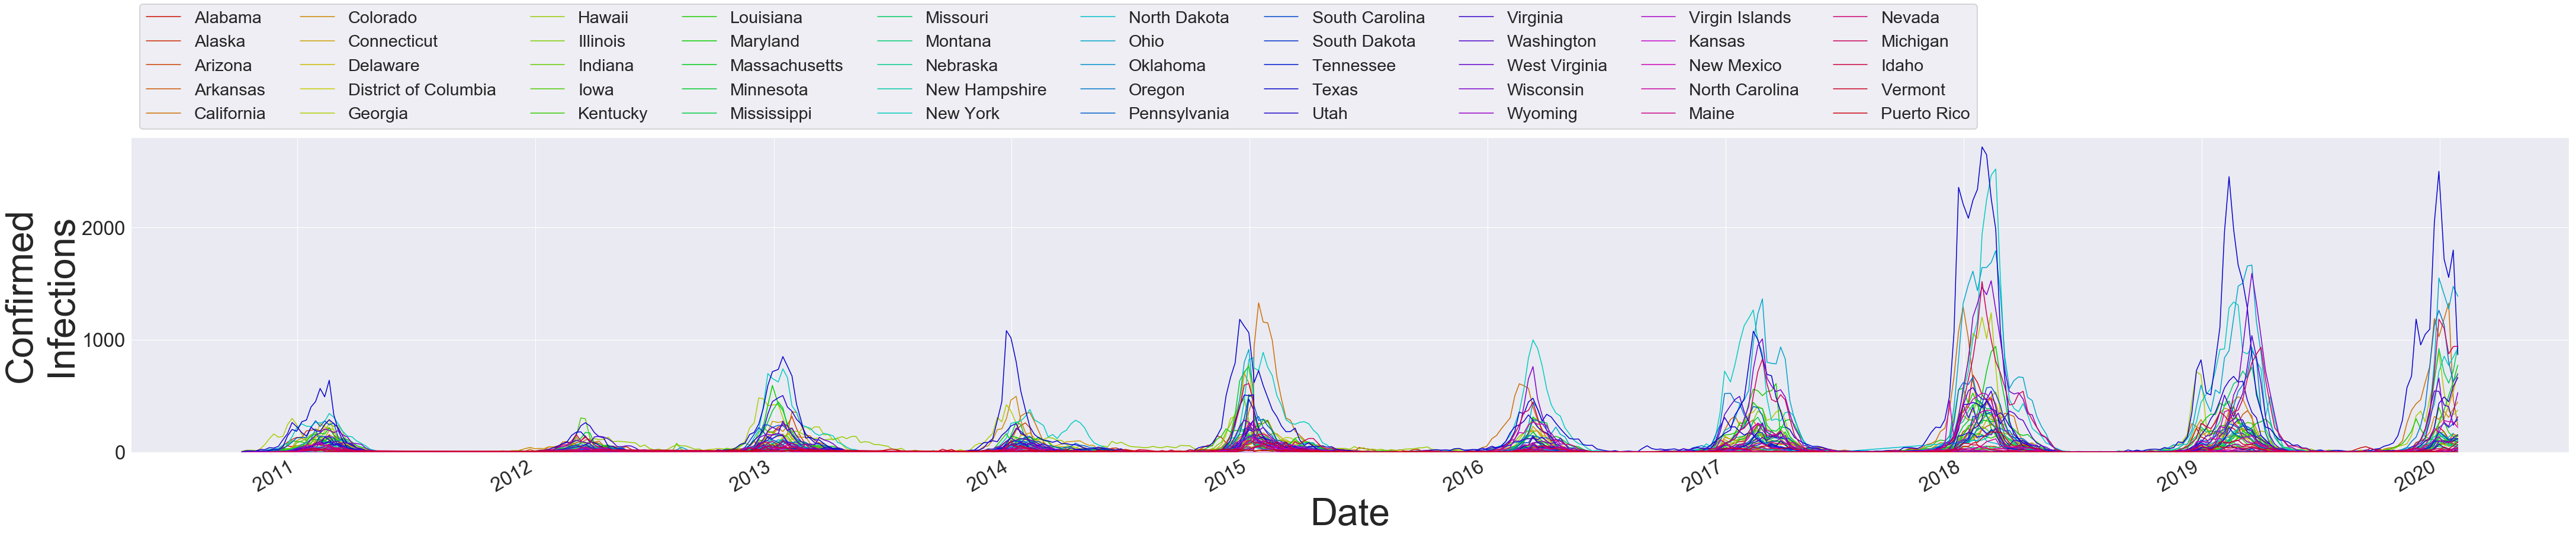

In [158]:
#a function to plot each grouping for EDA
def graph_states(df):
    
    sns.set_context("poster")

   
    number_colors=len(df.REGION.unique())
    labels = df.REGION.unique()
    sns.set(font_scale=3)
    g = sns.relplot(x="date", 
                    y="Confirmed_Infections", 
                    hue ="REGION", kind="line", 
                    data=df, 
                    height=10, 
                    aspect=6,
                    palette=sns.hls_palette(number_colors, l=.4, s=1),
                   legend=False)
    sns.set_context("poster")



    plt.legend(labels, ncol=10, bbox_to_anchor=(0, 1),
                  loc='lower left', fontsize='large')
    g.fig.autofmt_xdate()
    sns.set(font_scale=5)
    plt.ylim(0,2800) 
    plt.ylabel("Confirmed\nInfections", fontsize=64) 
    plt.xlabel("Date", fontsize=64)
    plt.plot()

    plt.savefig(df.REGION.unique()[0] + "01", bbox_inches = "tight") 
    
    
graph_states(group_states[0])

[None, None, None, None, None, None]

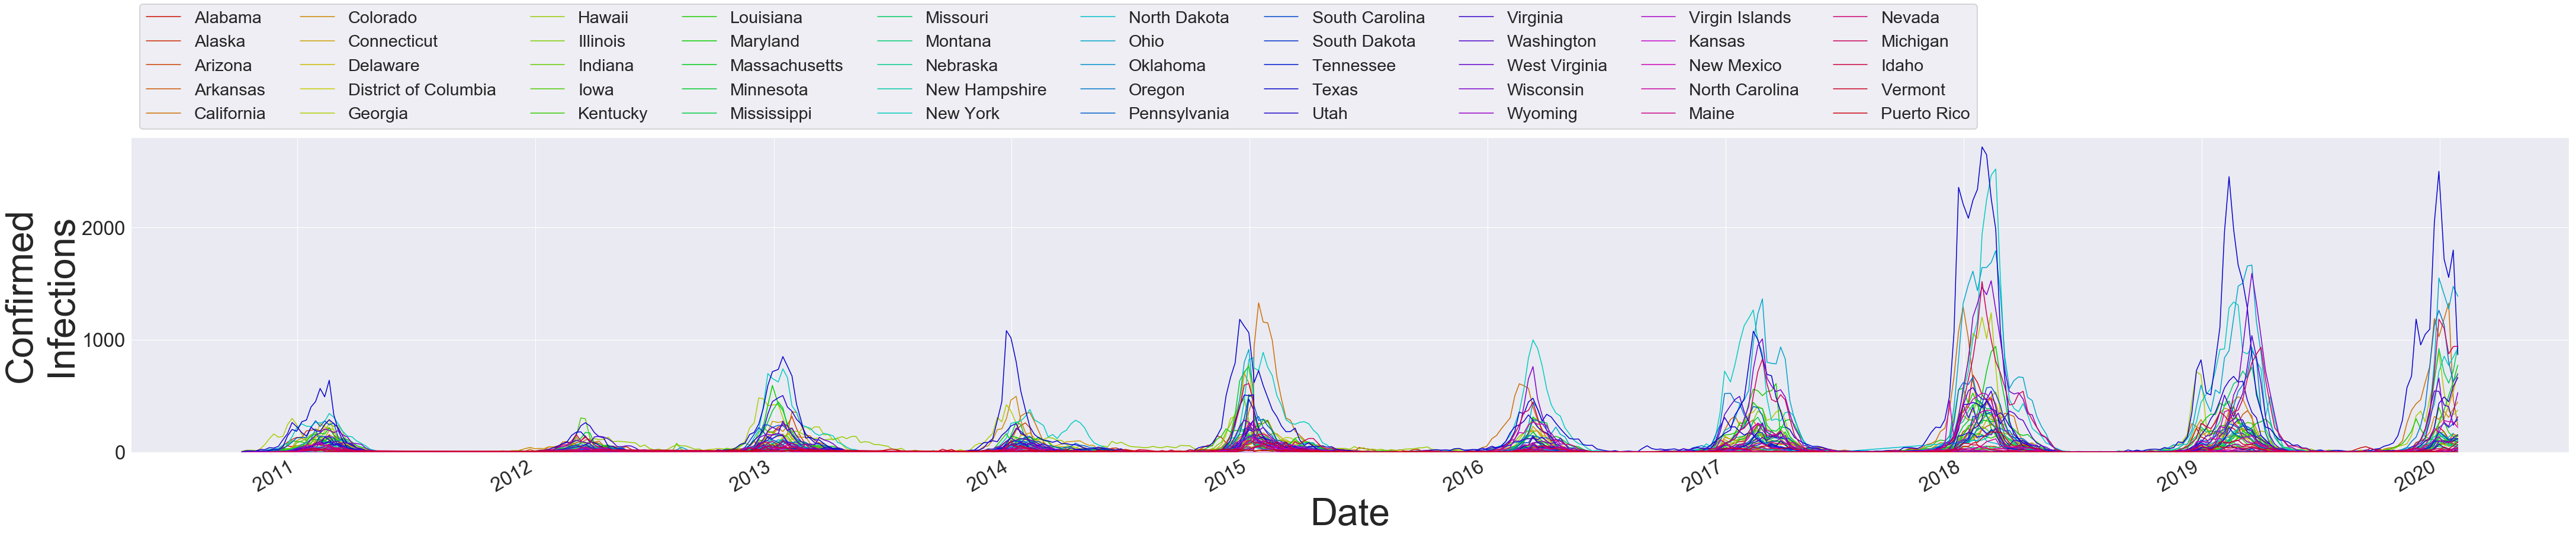

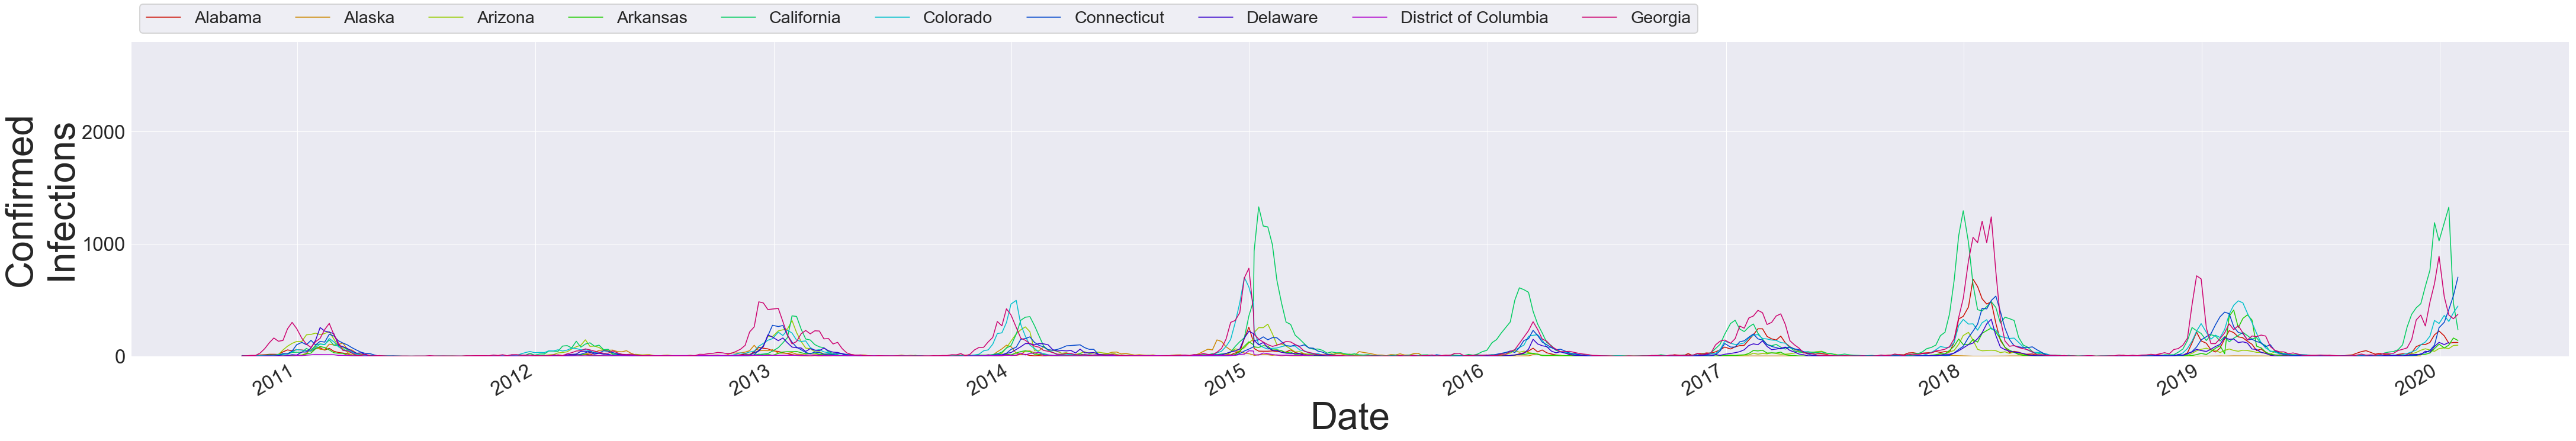

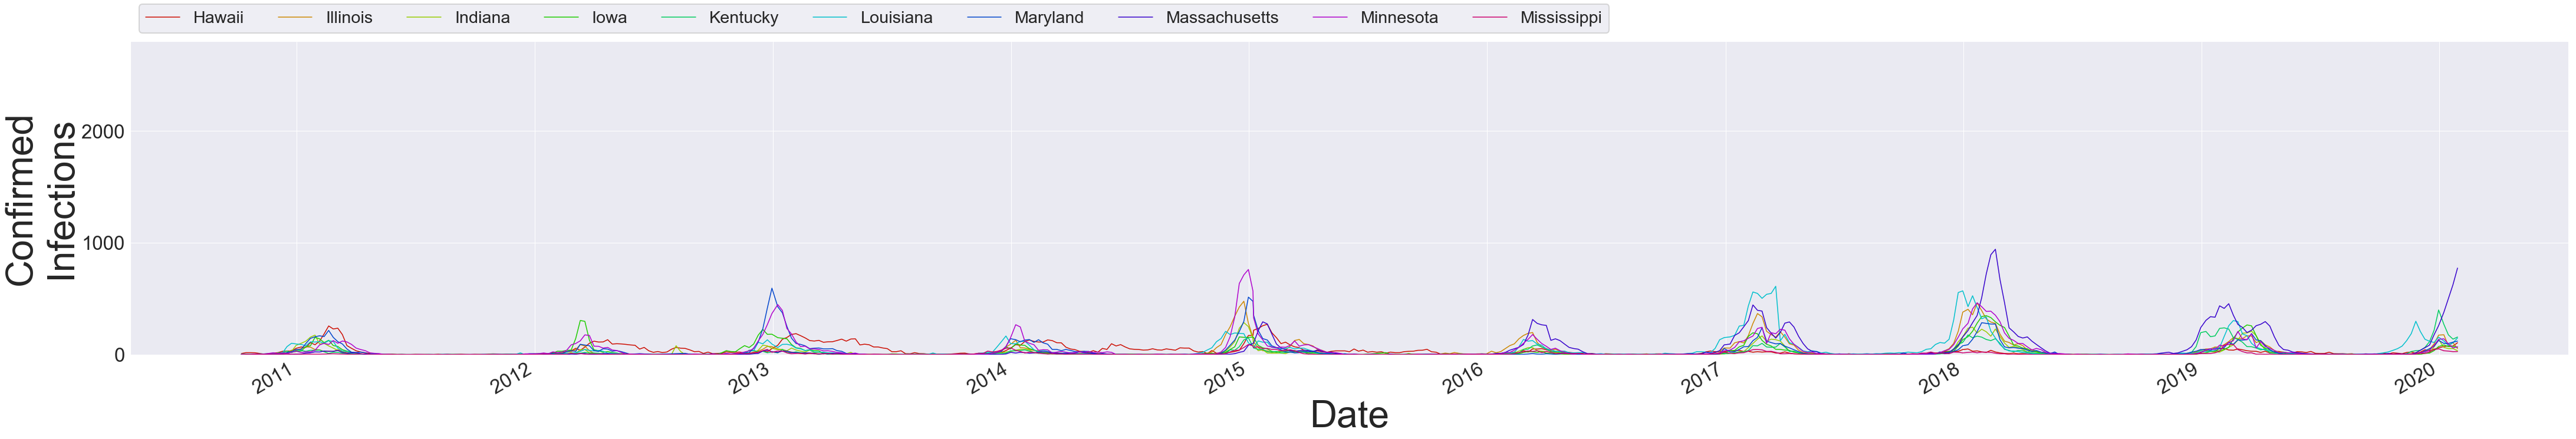

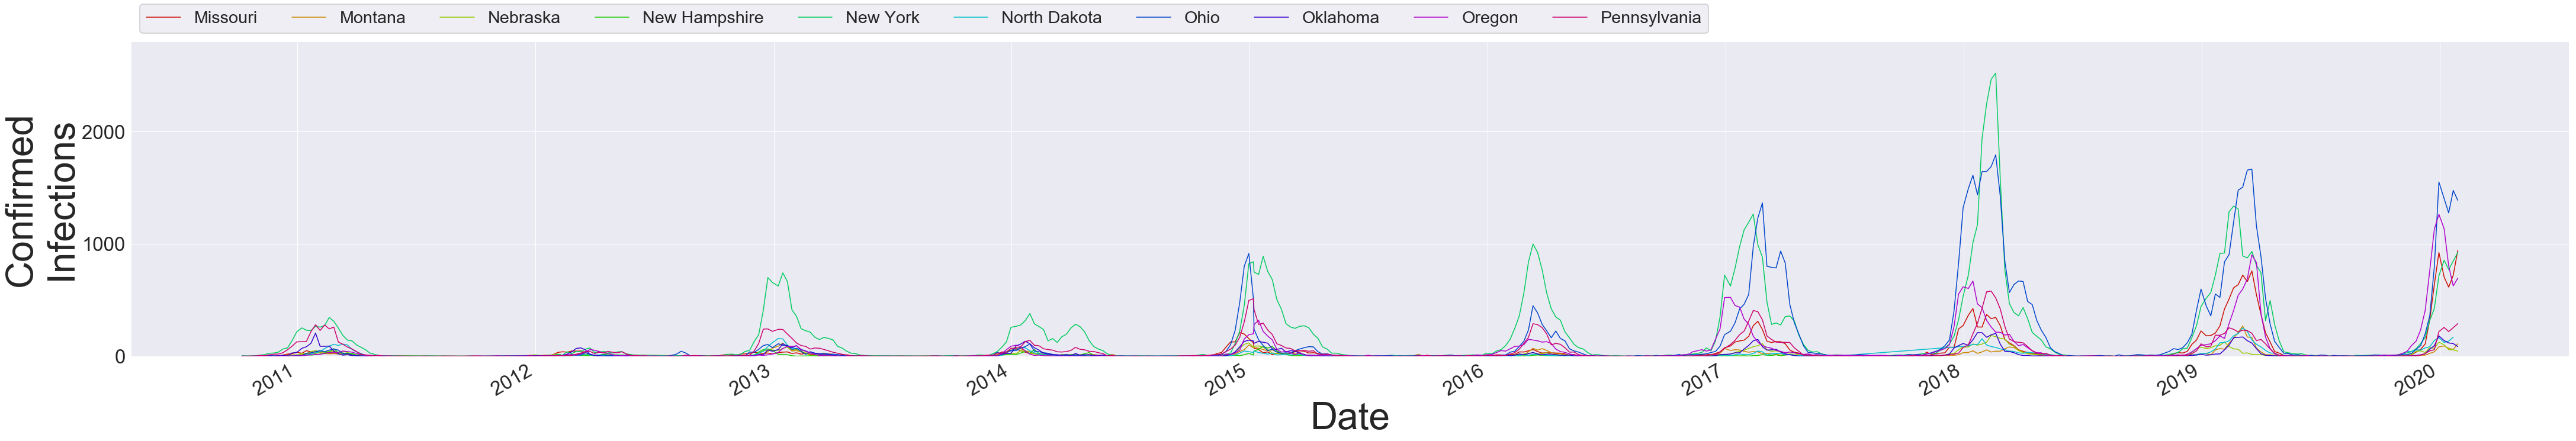

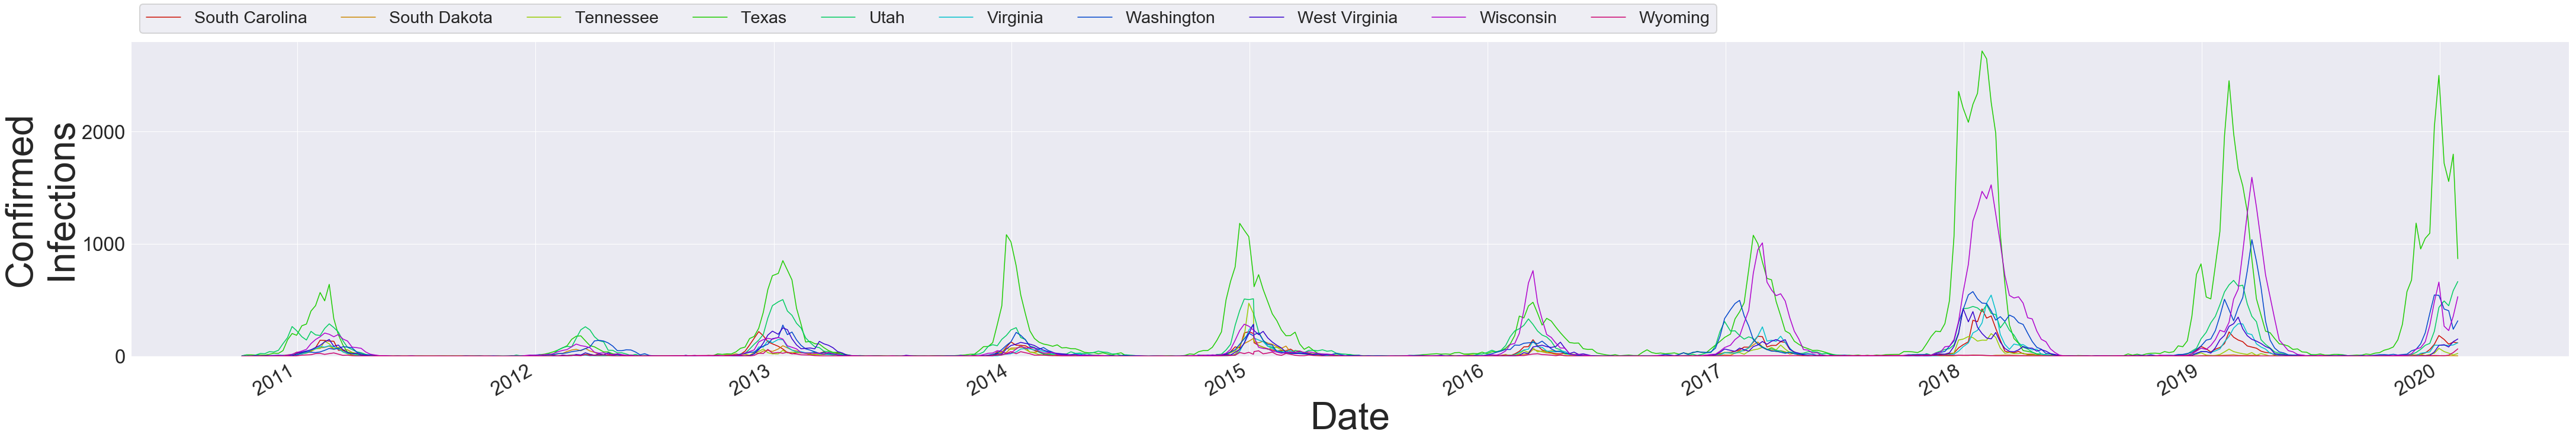

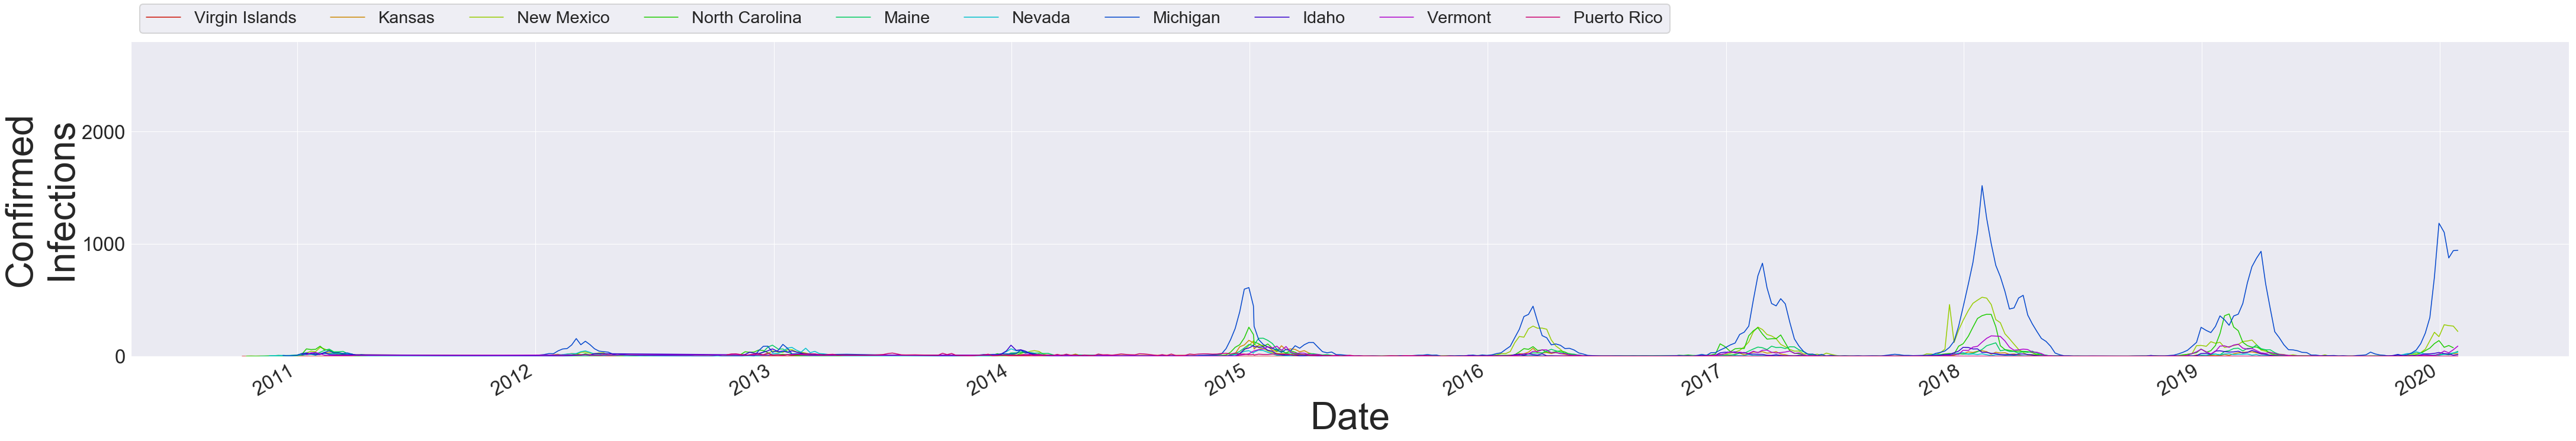

In [156]:
[graph_states(group) for group in group_states] 

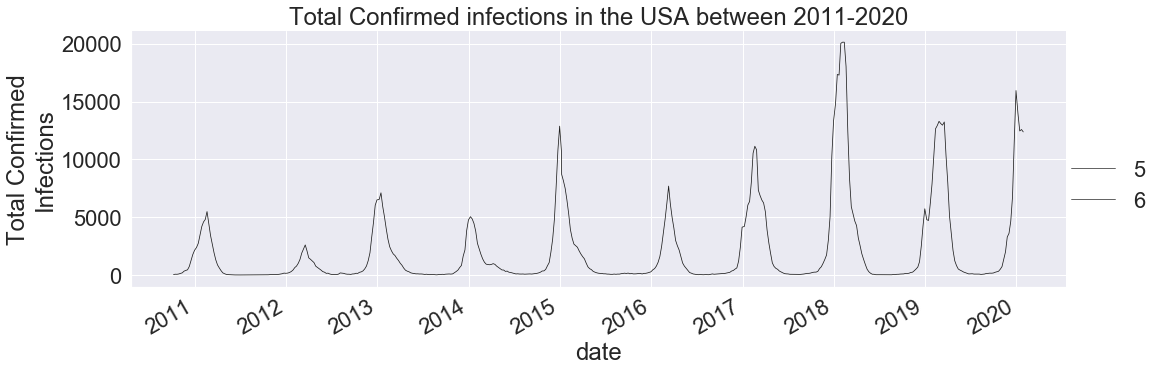

In [64]:
sns.set(font_scale=2)
g = sns.relplot(x="date", y="Confirmed_Infections",  kind="line", data=total_infections , size=6, aspect=3,
                color ="k") 
g.set_ylabels("Total Confirmed\nInfections") 
#plt.ylabel("Confirmed\nInfections")              
g.fig.autofmt_xdate()
plt.title("Total Confirmed infections in the USA between 2011-2020") 
plt.plot()
plt.savefig("total US infections", bbox_inches = "tight") 

In [65]:
#test Train split starting a year prior to the start of the 2019/2020 season

split_point = len(total_infections['Confirmed_Infections']) - 68
train_dataset, test_dataset = total_infections['Confirmed_Infections'][0:split_point], total_infections['Confirmed_Infections'][split_point:]


train_dataset.to_csv("CDC_training_data.csv")
test_dataset.to_csv("test_CDC_data.csv")



# Basic model: mean number of infections

In [66]:
basic_model = train_dataset.mean()
basic_model

basic_model_series = pd.Series(basic_model).repeat(len(test_dataset))
basic_model_series.index = test_dataset.index

basic_model_series.head()

date
2018-10-15    1717.464115
2018-10-22    1717.464115
2018-10-29    1717.464115
2018-11-05    1717.464115
2018-11-12    1717.464115
dtype: float64

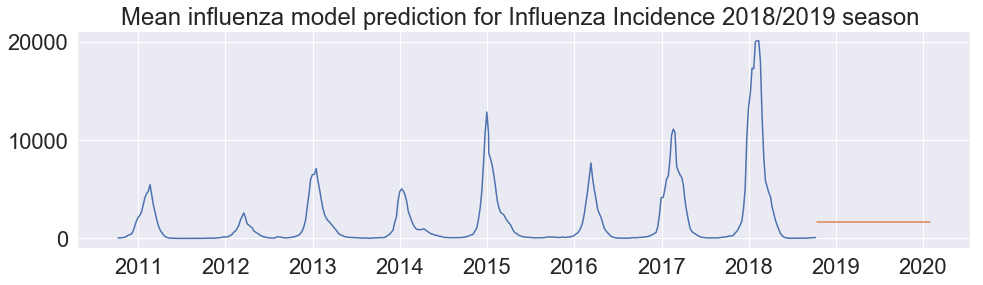

In [86]:

fig, ax = plt.subplots(1, figsize=(16, 4))

ax.plot(train_dataset.index, train_dataset)
ax.plot(basic_model_series.index, basic_model_series)
#ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='k', alpha=0.1)
ax.set_title("Mean influenza model prediction for Influenza Incidence 2018/2019 season ")
plt.savefig("images/Mean influenza model", bbox_inches = "tight") ;

In [68]:
rmse_basic_model = rms(test_dataset, basic_model_series[0:68])
print (" The root means square error is :",rms(test_dataset, basic_model_series[0:68]))

 The root means square error is : 5400.167142609439


#  fit the sesonla trend for by month

In [69]:
#fit the sesonla trend for by month
fst = fit_seasonal_trend(train_dataset)[0:48]


monthly_avg =[fst[i] for i in range(0,len(fst),4)]
months = [10,11,12,1,2,3, 4,5, 6,7, 8, 9]
month_avg_dict=dict( zip(months,monthly_avg))
month_avg_dict

{10: 137.35897435898278,
 11: 476.1562500000018,
 12: 3121.05,
 1: 3121.05,
 2: 5827.242424242425,
 3: 5682.093750000002,
 4: 3535.0,
 5: 1560.099999999995,
 6: 390.3750000000009,
 7: 121.03125000000182,
 8: 49.64999999999782,
 9: 56.25000000000091}

In [70]:
#to get the length of the and dates of the test set but for monthly averages
monthly_avg = pd.Series(0).repeat(len(test_dataset))
monthly_avg.index = test_dataset.index

In [71]:
#fill in the values of each week that corresond to their monthly average
for i in range(len(monthly_avg)):
   monthly_avg[i]= month_avg_dict[monthly_avg.index[i].month]

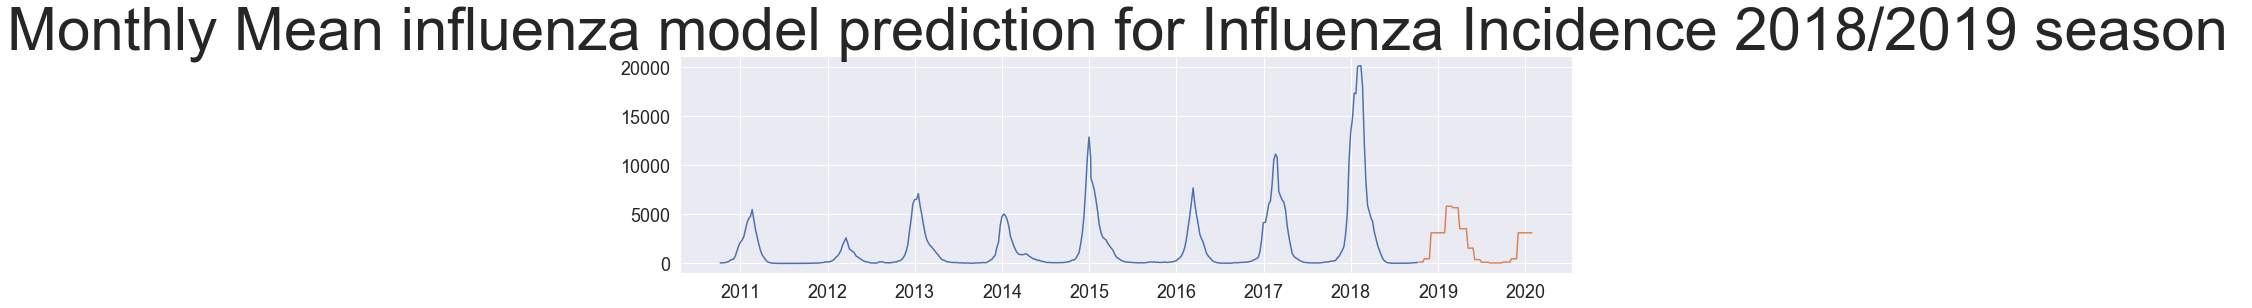

In [202]:
fig, ax = plt.subplots(1, figsize=(16, 4))

ax.plot(train_dataset.index, train_dataset)
ax.plot(monthly_avg.index, monthly_avg)
#ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='k', alpha=0.1)
ax.set_title("Monthly Mean influenza model prediction for Influenza Incidence 2018/2019 season ")
plt.savefig("images/Monthly Mean influenza model", bbox_inches = "tight") ;

In [73]:
rmse_montly_average_model = rms(test_dataset, monthly_avg)
print (" The root means square error is :",rmse_montly_average_model   )

 The root means square error is : 4007.233533029401


In [74]:
test_dataset.head()

date
2018-10-15    137.0
2018-10-22    129.0
2018-10-29    153.0
2018-11-05    219.0
2018-11-12    243.0
Name: Confirmed_Infections, dtype: float64

In [75]:
weekly_avg = pd.Series(0).repeat(len(test_dataset))
weekly_avg.index = test_dataset.index


In [76]:
weeks = list(range(1,53))
weekly_fit = pd.Series(fit_weekly_seasonal_trend(train_dataset))
weekly_fit.index = train_dataset.index




In [77]:
#to zip the weeks and weekly avergae they have to be in the same order by the weekly_fit index, And since we are
#making a dictionary we can only have 52 unique weeks

week_order_by_index =[weekly_fit.index[i].week for i in range(len(weeks))]


weekly_avg_dict=dict( zip(week_order_by_index,weekly_fit))
weekly_fit[0]== test_dataset[2]

False

In [78]:
weekly_avg.index[0].week

42

In [79]:
for i in range(len(weekly_avg)):
    weekly_avg[i]= weekly_avg_dict[weekly_avg.index[i].week]
    

In [80]:
test_dataset.head()

date
2018-10-15    137.0
2018-10-22    129.0
2018-10-29    153.0
2018-11-05    219.0
2018-11-12    243.0
Name: Confirmed_Infections, dtype: float64

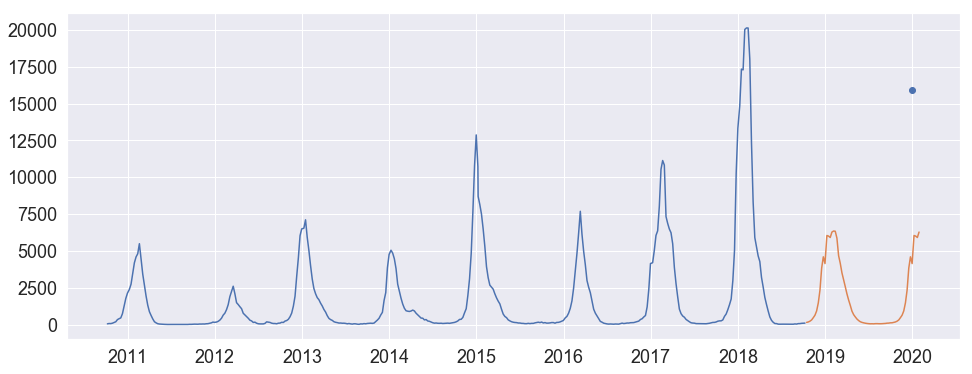

In [212]:
fig, ax = plt.subplots(1, figsize=(16, 6))

ax.plot(train_dataset.index, train_dataset)
ax.plot(weekly_avg.index, weekly_avg)
ax.plot(weekly_avg.index[-5],15957, 'bo')
#ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='k', alpha=0.1)
#ax.set_title("Weekly Mean influenza model prediction for Influenza Incidence 2018/2019 season ")
plt.savefig("images/Weekly Mean influenza model") ;

In [82]:
rmse_weekly_average_model = rms(test_dataset, weekly_avg)
print (" The root means square error is :",rmse_weekly_average_model  )

 The root means square error is : 3797.550599902986


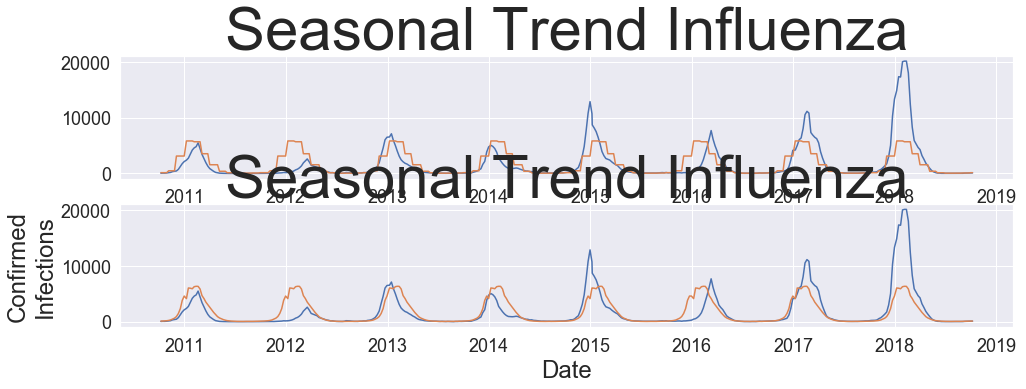

In [213]:
influenza_seasonal_trend = fit_seasonal_trend(train_dataset)

fig, axs = plt.subplots(2, figsize=(16, 5))

plot_seasonal_trend(axs[0], 'Influenza', train_dataset)
plot_weekly_seasonal_trend(axs[1], "Influenza", train_dataset)

plt.tight_layout()

influenza_seasonal_trend = fit_weekly_seasonal_trend(train_dataset)
influenza_seasonal_detrended = train_dataset - influenza_seasonal_trend

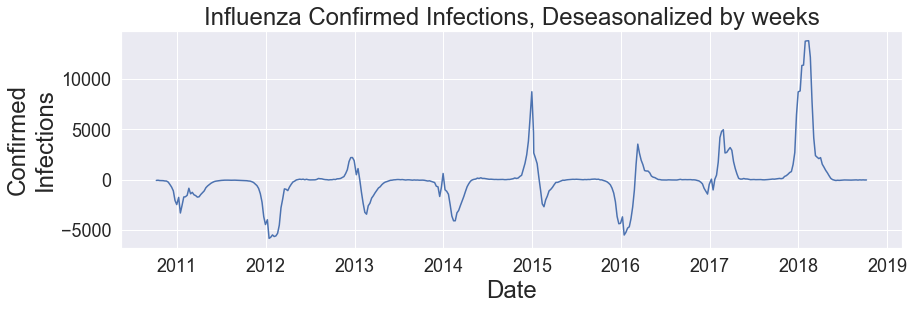

In [192]:
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(train_dataset.index, influenza_seasonal_detrended)
plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18)

plt.ylabel("Confirmed\nInfections", fontsize=24) 
plt.xlabel("Date", fontsize=24)
ax.set_title("Influenza Confirmed Infections, Deseasonalized by weeks", fontsize=24)
plt.savefig("images/deseasonalized by weeks");

In [135]:
#number_colors=ten_year_influenza_confirmed.REGION.unique()
labels = ten_year_influenza_confirmed.REGION.unique()
sns.set(font_scale=3)
sns.set_context("poster")
g = sns.relplot(x="date", 
                y="Confirmed_Infections", 
                hue ="REGION", kind="line", 
                data=ten_year_influenza_confirmed, 
                height=10, 
                aspect=6,
                palette=sns.hls_palette(52, l=.4, s=1),
                legend=False)
sns.set_context("poster")



plt.legend(labels, ncol=10, bbox_to_anchor=(0, 1),loc='lower left', fontsize='large')
g.fig.autofmt_xdate()
sns.set(font_scale=5)
plt.ylim(0,2800) 
plt.ylabel("Confirmed\nInfections", fontsize=64) 
plt.xlabel("Date", fontsize=64)
plt.plot()

plt.savefig(df.REGION.unique()[0], bbox_inches = "tight") 


ValueError: Could not interpret input 'REGION'

In [163]:
grouped= ten_year_influenza_confirmed.groupby(["REGION"]).sum().reset_index()
grouped.head()

,REGION,TOTAL SPECIMENS,A (2009 H1N1),A (H1),A (H3),A (Subtyping not Performed),A (Unable to Subtype),B,H3N2v,TOTAL A,TOTAL B,Confirmed_Infections
0,Alabama,134194.0,270.0,0.0,969.0,811.0,0.0,785.0,0.0,10602.0,4434.0,15036.0
1,Alaska,19872.0,1002.0,0.0,2614.0,102.0,0.0,788.0,0.0,3819.0,817.0,4636.0
2,Arizona,77795.0,2308.0,0.0,5505.0,211.0,0.0,1673.0,0.0,10699.0,2947.0,13646.0
3,Arkansas,44342.0,296.0,0.0,563.0,835.0,0.0,608.0,0.0,5952.0,2309.0,8261.0
4,California,360269.0,1820.0,0.0,7654.0,4584.0,0.0,2690.0,0.0,33207.0,13636.0,46843.0


In [166]:

grouped = grouped.sort_values('Confirmed_Infections', ascending=False)

In [167]:
grouped.to_csv("/Users/GuntherUlvanget/Capstone/Capstone2/Influenza/data/grouped.csv")

In [194]:
total_infections


,date,TOTAL SPECIMENS,A (2009 H1N1),A (H1),A (H3),A (Subtyping not Performed),A (Unable to Subtype),B,H3N2v,TOTAL A,TOTAL B,Confirmed_Infections
date,,,,,,,,,,,,
2010-10-08,2010-10-08,3200.0,7.0,0.0,16.0,13.0,0.0,9.0,0.0,36.0,9.0,45.0
2010-10-15,2010-10-15,3501.0,11.0,0.0,27.0,11.0,0.0,18.0,0.0,49.0,18.0,67.0
2010-10-22,2010-10-22,3572.0,7.0,0.0,24.0,8.0,0.0,23.0,0.0,39.0,23.0,62.0
2010-10-29,2010-10-29,3702.0,13.0,0.0,37.0,15.0,0.0,23.0,0.0,65.0,23.0,88.0
2010-11-05,2010-11-05,4028.0,11.0,0.0,45.0,21.0,0.0,57.0,0.0,77.0,57.0,134.0
2010-11-12,2010-11-12,4691.0,14.0,0.0,52.0,25.0,0.0,95.0,0.0,91.0,95.0,186.0
2010-11-19,2010-11-19,4825.0,22.0,0.0,94.0,47.0,0.0,168.0,0.0,163.0,168.0,331.0
2010-11-26,2010-11-26,4746.0,10.0,0.0,124.0,57.0,0.0,204.0,0.0,191.0,204.0,395.0
2010-12-03,2010-12-03,5274.0,29.0,0.0,149.0,61.0,0.0,209.0,0.0,239.0,209.0,448.0


In [195]:
15957.0-weekly_avg_dict[52]

11358.555555555551

In [199]:
weekly_avg.index[-5]

Timestamp('2019-12-31 00:00:00')